<font size="18">With Bubbles, No Troubles</font>

In [1]:
# set this notebook to use a large part of the browser window width
from IPython.core.display import HTML, display
display(HTML("<style>.container { width:80% !important; }</style>"))

# Introduction

We consider the problem of allocating all people p in a set P a spot (x,y), where
... see README.txt i  this dir.

# Model Setup



In [2]:
from IPython.display import Image
#Image(filename='ChainGangOnAFence.png', width=1000, height=3000)

Using Kirchhoff current and voltege laws we get the equations.

In [3]:
from gurobipy import *
import random

random.seed(10)

program = 'WithBubblesNoTroubles'

# generate some bubbles with people:
max_persons_per_bubble = 5
B = 10

p = 0
bubbles = []
persons = []
for b in range(0, B):
    bubble_b_size = random.randint(1, max_persons_per_bubble)
    for i in range(0, bubble_b_size):
        bubbles.append(b)
        persons.append(p)        
        p += 1

P = len(persons)
print('P = {:d}'.format(P))
print('persons = ')
print(persons)

print('B = {:d}'.format(B))
print('bubbles = ')
print(bubbles)

dSameBubbleMLo = 0.5 # meter
dSameBubbleMHi = 4.0 # meter

dOtherBMLo = 1.5 # meter

def model(xlo=0, xhi=100,
          ylo=0, yhi=100):
    
    verbose = 0
        
    m = Model()

    # create all the 4N continuous variables:
    x = m.addVars(persons, lb=[xlo]*P, ub=[xhi]*P, vtype=GRB.CONTINUOUS, name='x')  
    y = m.addVars(persons, lb=[ylo]*P, ub=[yhi]*P, vtype=GRB.CONTINUOUS, name='y')  

    assert len(x) == P
    assert len(y) == P

    max_quad_expr = 0
    # (1) create all the 3N linear current constraints:
    for p1 in persons:  # there are P of them: 0..P-1
        for p2 in persons:  # there are P of them: 0..P-1
            if p1 < p2:
                quad_expr = (x[p2] - x[p1]) *  (x[p2] - x[p1]) + (y[p2] - y[p1]) * (y[p2] - y[p1])
                if bubbles[p1] == bubbles[p2]:  # pair is in same bubble, pull together
                    m.addConstr(quad_expr >= dSameBubbleMLo**2, 'sameMLo_p{:d}_p{:d}'.format(p1,p2))
                    m.addConstr(quad_expr <= dSameBubbleMHi**2, 'sameMHi_p{:d}_p{:d}'.format(p1,p2))
                else: # pair is not in same bubble, separate by pushing away from each other
                    m.addConstr(quad_expr >= dOtherBMLo**2, 'otherMLo_p{:d}_p{:d}'.format(p1,p2))
                    max_quad_expr += quad_expr

                    
    #m.setObjective(max_quad_expr, GRB.MAXIMIZE)
                    
    m.setParam(GRB.Param.NonConvex, 2)  
    m.setParam(GRB.Param.MIPGap, 0.05)

    m.write(program + '.lp')
    m.optimize()
    print(x)
    print(y)
    return m, x, y
    
m, x, y = model()

P = 33
persons = 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
B = 10
bubbles = 
[0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9]
Using license file /Library/gurobi901/gurobi.lic
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter MIPGap to 0.05
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (mac64)
Optimize a model with 0 rows, 66 columns and 0 nonzeros
Model fingerprint: 0x54388d46
Model has 576 quadratic constraints
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [1e+00, 2e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [0e+00, 0e+00]
  QRHS range       [2e-01, 2e+01]

Continuous model is non-convex -- solving as a MIP.

Presolve time: 0.02s
Presolved: 2706 rows, 1188 column

In [4]:
# Select B different colors to display the bubbles in different colors,
# so that the use can immediately see that bubbles are well separated.
import numpy as np
import colorsys

def _get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

bubble_to_color_map = _get_colors(B)

In [5]:
def print_and_convert_results(m, x, y):     
    for var_name, var_struct in list(zip(['x', 'y'], [x, y])):
        values = m.getAttr('x', var_struct)
        s = var_name
        s += ' (m) = '
        vals = [(values[v]) for v in values]
        do_print = False
        if do_print:
            print(s)
            print(vals)
        
        if var_name == 'x':
            x_values = vals
            if do_print:
                print(x_values)
        else:
            y_values = vals
            if do_print:
                print(y_values)
    return x_values, y_values

    
x_values, y_values = print_and_convert_results(m, x, y)


import matplotlib


import pandas as pd
df = pd.DataFrame(columns=[ "person", "bubble", "x", "y", "color"])
df["person"] = persons
df["bubble"] = bubbles
df["color"] = [matplotlib.colors.to_hex(bubble_to_color_map[b]) for b in bubbles]
df["x"] = x_values
df["y"] = y_values

df

,person,bubble,x,y,color
0,0,0,5.454364,54.309254,#f80d0d
1,1,0,2.575383,54.303016,#f80d0d
2,2,0,4.838306,54.190044,#f80d0d
3,3,0,2.534978,56.524450,#f80d0d
4,4,0,3.987220,55.508142,#f80d0d
5,5,1,14.646138,7.191977,#f79e19
6,6,2,3.666348,58.316146,#c6f312
7,7,2,4.497842,60.013801,#c6f312
8,8,2,5.608803,59.096733,#c6f312
9,9,2,5.635983,60.950545,#c6f312


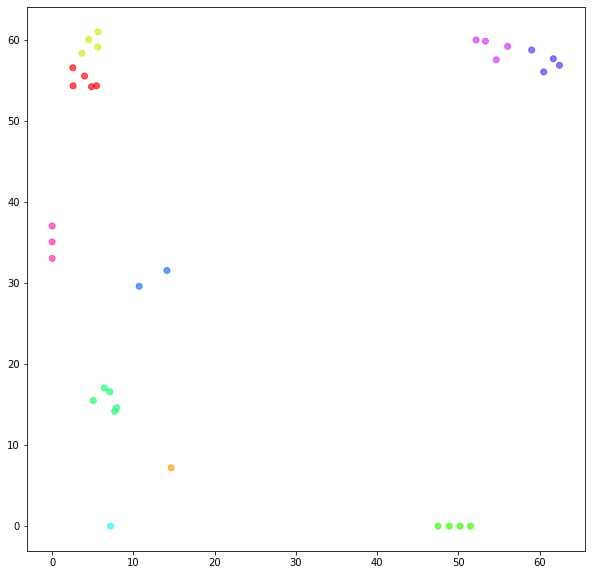

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
plt.scatter(df["x"], df["y"], color=df["color"], alpha=0.7)
plt.show()